In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Node:
    def __init__(self, b, col, value = None, height = 0, Mode = None):
        self.b = b
        self.col = col
        self.value = value
        self.LNode = None
        self.RNode = None
        self.height = height
        self.Mode = Mode

In [3]:
def Gini(y):
    Gini = 1
    try:
        N = y.shape[0]
    except:
        return Gini
    
    for k in [1, -1]:
        Gini += -(np.sum(y == k)/N)**2
    return Gini

In [4]:
def DStump(X, y):
    row, col = X.shape
    X_sort = np.sort(X, axis = 0)
    thresList = np.r_[[X_sort[0,:]-1], (X_sort[0:-1,:] + X_sort[1:,:])/2, [X_sort[-1,:]+1]]
    minPurity = y.shape[0]
    DSb = 0
    DScol = 0
    for c in range(col):
        for i in range(thresList.shape[0]):
        
            y0 = y[ X[:,c] <  thresList[i,c]]
            y1 = y[ X[:,c] >= thresList[i,c]]
            Purity = y0.shape[0]*Gini(y0)+y1.shape[0]*Gini(y1)
            if minPurity > Purity:
                minPurity = Purity
                DSb = thresList[i,c]
                DScol = c
               
    return DSb, DScol

In [13]:
def DTree(X, y):
    
    if (np.sum(y!=y[0])==0 or X.shape[0]==1 or np.sum(X!=X[0, :])==0):
        node = Node(None, None, y[0])
        return node
    
    DSb, DScol = DStump(X, y)
    #print(DSb,DScol)
    LX = X[ (X[:, DScol] < DSb) , :]
    RX = X[ (X[:, DScol] >= DSb), :]
    
    Ly = y[ (X[:, DScol] < DSb) ]
    Ry = y[ (X[:, DScol] >= DSb)]
    
    if (sum(y == -1) >sum(y == 1)):
        Mode = -1
    else:
        Mode = 1
        
    node = Node(DSb, DScol, Mode = Mode)
    
    
    node.LNode = DTree(LX, Ly)
    node.RNode = DTree(RX, Ry)
 
    
    return node

In [6]:
data = pd.read_csv('hw3_train.dat', sep='\s+', header=None)
X_train = data.iloc[:,0:2].values
y_train = data.iloc[:,2].values
data = pd.read_csv('hw3_test.dat', sep='\s+', header=None)
X_test = data.iloc[:,0:2].values
y_test = data.iloc[:,2].values

In [7]:
def nodeH(node):
    
    h = 0 
    if node == None:

        return 
    if node.LNode == None and node.RNode == None:
        
        if node.height > h: 
            h = node.height
        return h

    if node.LNode != None:

        lh = nodeH(node.LNode)
    if node.RNode != None:

        rh = nodeH(node.RNode)
        
    print('MaxH=',h)
    return max(h,lh,rh)


In [8]:
def internal_node(node):
    
    if node == None:
        
        return 0
    if node.LNode == None and node.RNode == None:
        print('==End',node.value, node.height)
        return 0
    l = 0; r = 0
    if node.LNode != None:

        print('L',node.b,node.col, node.height+1,'Mode=',node.Mode,'Value=',node.value)
        l = internal_node(node.LNode)
    if node.RNode != None:

        print('R',node.b,node.col,node.height+1,'Mode=',node.Mode,'Value=',node.value)
        r = internal_node(node.RNode)
    return 1 + l + r


In [9]:
def setNodeH(node):
    
    if node == None:
        
        return 0
    if node.LNode == None and node.RNode == None:

        return 0

    if node.LNode != None:
        LH = node.height + 1
        node.LNode.height = LH

        setNodeH(node.LNode)
    if node.RNode != None:
        RH = node.height + 1
        node.RNode.height = RH

        setNodeH(node.RNode)
    return node


In [43]:
def predictDT(node, X,MaxH=np.inf):
    if node.value is not None:
        
        return node.value
        
    b = node.b
    c = node.col
    
    if node.height >= MaxH:
        #print('height' , node.height)
        return node.Mode
    
    if X[c] < b:
        return predictDT(node.LNode,X, MaxH)
    else:
        return predictDT(node.RNode,X, MaxH)
    
def predict(node, Xall,MaxH=np.inf):
    row = Xall.shape[0]
    ypred = np.zeros(row)
    for i in range(row):
        ypred[i] = predictDT(node,Xall[i,:],MaxH)
    return ypred

def err01(ypred, y):
    return np.sum(ypred != y)/y.shape[0]

In [39]:
data = pd.read_csv('hw3_train.dat', sep='\s+', header=None)
X_train = data.iloc[:,0:2].values
y_train = data.iloc[:,2].values



In [139]:
data_test = pd.read_csv('hw3_test.dat', sep='\s+', header=None)
X_test = data_test.iloc[:,0:2].values
y_test = data_test.iloc[:,2].values

In [154]:
err_gt = []
err_rf_in = []
err_rf_out = []
RF_pred_in = np.zeros(100)
RF_pred_out = np.zeros(1000)
T = 30000
for i in range(T):
    data_bs = data.sample(n=80, replace=True)
    X_train_bs = data_bs.iloc[:,0:2].values
    y_train_bs = data_bs.iloc[:,2].values
    node_bs = setNodeH(DTreeFull(X_train_bs, y_train_bs))
    
    y_pred_in = predict(node_bs,X_train)
    RF_pred_in = RF_pred_in + y_pred_in/T
    
    y_pred_out = predict(node_bs,X_test)
    RF_pred_out = RF_pred_out + y_pred_out/T
    
    
    predict(node_bs,X_train)
    err_gt = err_gt + [err01(predict(node_bs,X_train),y_train)]
    err_rf_in = err_rf_in + [err01(np.sign(RF_pred_in), y_train)]
    err_rf_out = err_rf_out + [err01(np.sign(RF_pred_out), y_test)]
    

C:\Users\Morris\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Q14:

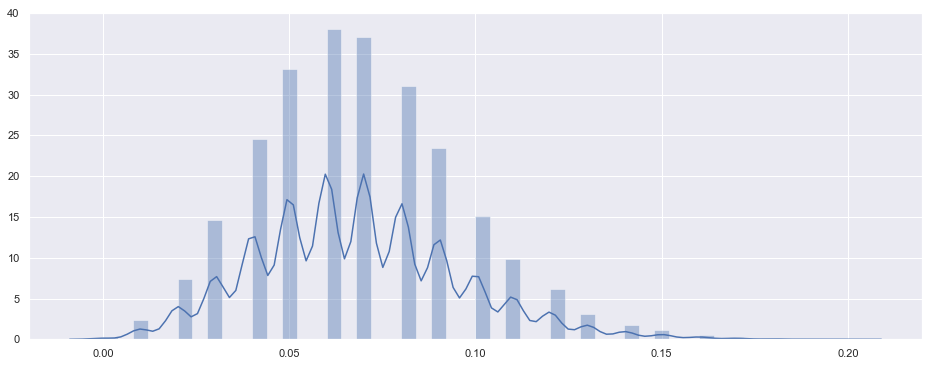

In [163]:

sns.set()
plt.figure(figsize=(16, 6))
ax = sns.distplot(err_gt)


Q15: 第一張圖是Ein,第二是Eout。第三、四張是只畫前500個。/

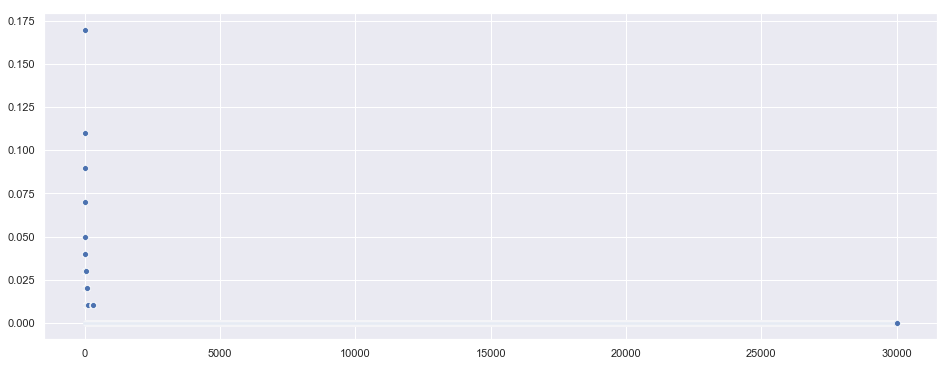

In [156]:
plt.figure(figsize=(16, 6))
sns.scatterplot(range(T),err_rf_in)

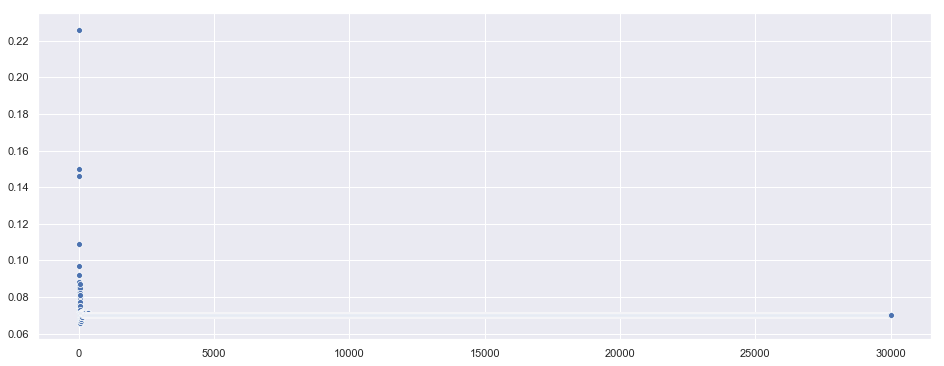

In [157]:
plt.figure(figsize=(16, 6))
sns.scatterplot(range(T),err_rf_out)

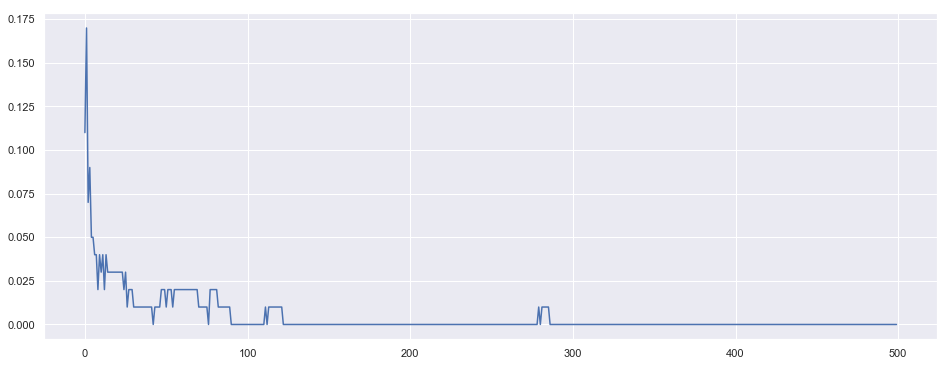

In [173]:
plt.figure(figsize=(16, 6))
sns.lineplot(range(500),err_rf_in[0:500])

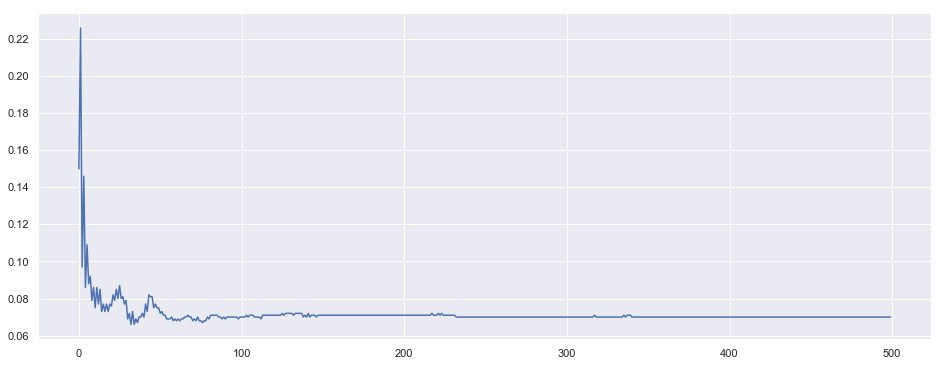

In [174]:
plt.figure(figsize=(16, 6))
sns.lineplot(range(500),err_rf_out[0:500])

Q16:從最後兩張圖來看，Ein在前100次下降的非常快，在100次之後就幾乎為0。
    但Eout不會完全跑到0，最後大概在0.05